In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
vgsales_dirty = pd.read_csv('../input/videogamesales/vgsales.csv')


## Check dataset on null cells

In [2]:

vgsales_dirty.isnull().sum(axis = 0)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [8]:
vgsales = vgsales_dirty.dropna(subset=['Year', 'Publisher'])
vgsales = vgsales.iloc[:, 2:]
vgsales.Year = vgsales.Year.astype(np.int64)
vgsales.isnull().any()
vgsales.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Plan
1. Analize dataset
2. Try to predict missed release years of games
3. Create sales prediction 

# Let's look at the data

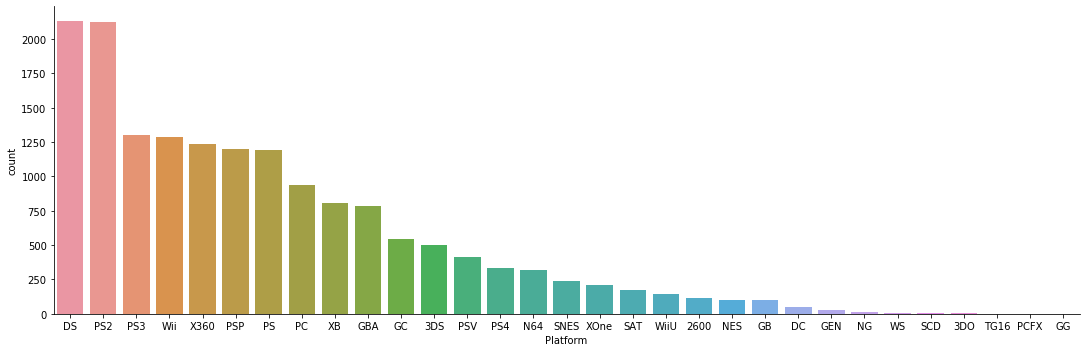

In [4]:
 
sns.catplot(x="Platform", kind="count", data=vgsales, aspect=3, order = vgsales.Platform.value_counts().index);

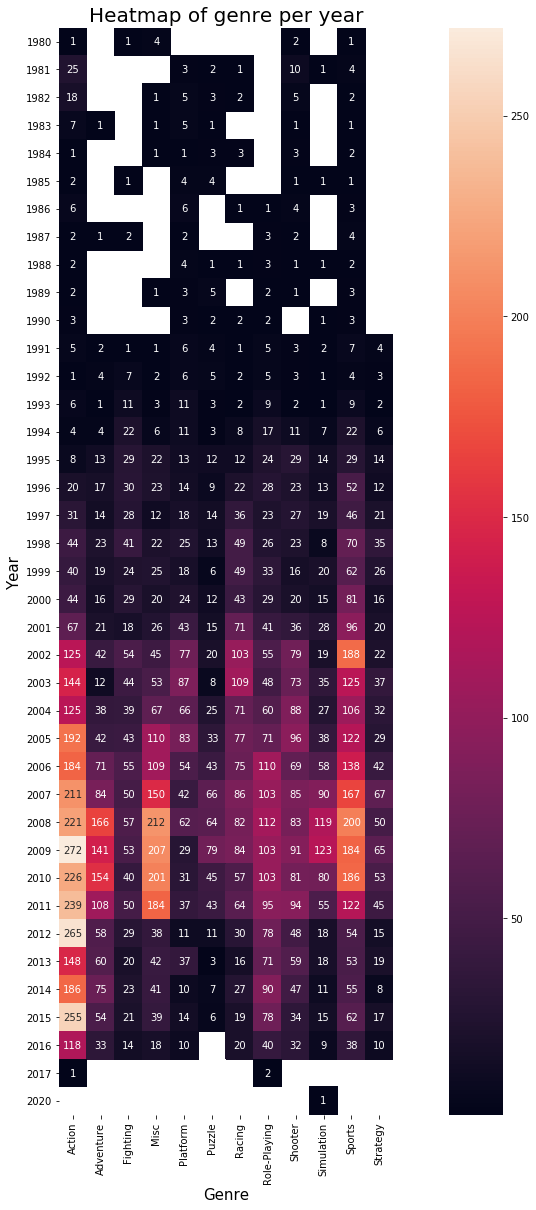

In [42]:
 
grouped_single = vgsales.groupby(["Year", "Genre"]).agg({'Other_Sales': ['count']}).reset_index()
piv = pd.pivot_table(data=vgsales,
                    index='Year',
                    values='Other_Sales',
                    columns='Genre', aggfunc='count') 
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(piv, annot=True, fmt=".0f", square=1,ax=ax)
loc, labels = plt.yticks()
ax.set_yticklabels(rotation=0, labels=labels)
plt.title('Heatmap of genre per year', fontsize = 20) # title with fontsize 20
plt.xlabel('Genre', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Year', fontsize = 15) # y-axis label with fontsize 15
plt.show()

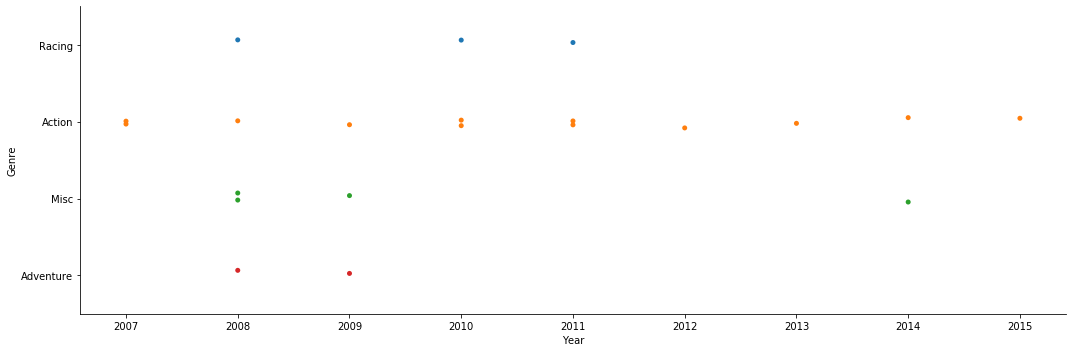

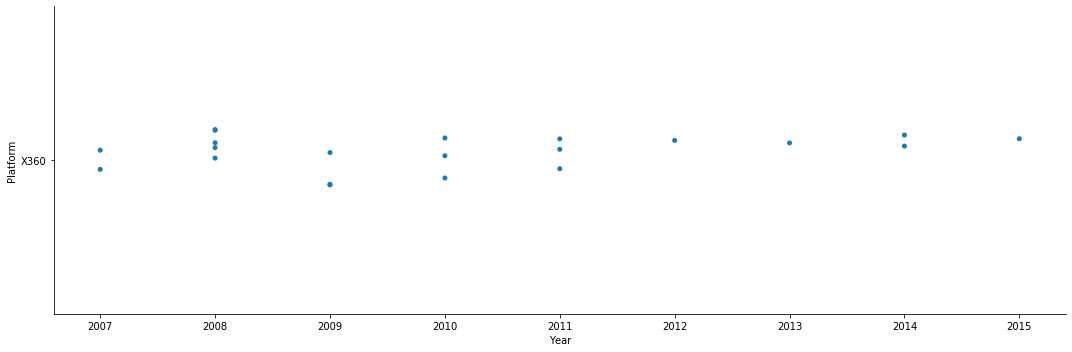

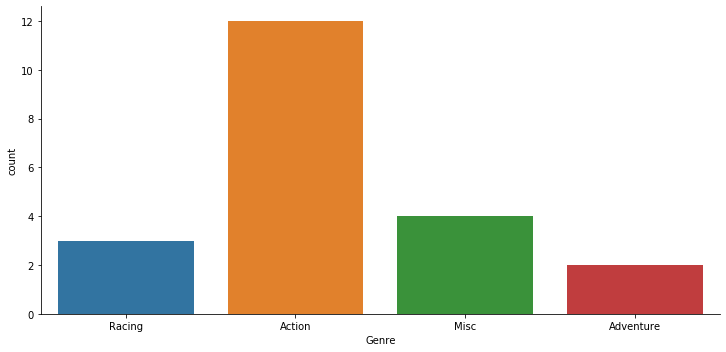

In [69]:
disneyInteractiveStudios = vgsales[vgsales.Publisher == "Disney Interactive Studios"]
disneyInteractiveStudios = disneyInteractiveStudios[disneyInteractiveStudios.Platform == "X360"]
sns.catplot(x="Year", y="Genre", data=disneyInteractiveStudios, aspect=3, estimator=np.sum );
sns.catplot(x="Year", y="Platform", data=disneyInteractiveStudios, aspect=3, estimator=np.sum );
sns.catplot(x="Genre", kind="count", data=disneyInteractiveStudios, aspect=2);

In [95]:
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
transformedCT = vgsales.iloc[:,:]
transformedCT.Platform = le.fit_transform(transformedCT.Platform)
transformedCT.Year = le.fit_transform(transformedCT.Year)
transformedCT.Genre = le.fit_transform(transformedCT.Genre)
transformedCT.Publisher = le.fit_transform(transformedCT.Publisher)
transformedCT.head()
scatter_matrix(vgsales, alpha=0.05, figsize=(20, 20));

In [96]:
transformedCT.corr()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Platform,1.000000,0.167686,0.026665,-0.017938,0.041976,0.046748,-0.079621,0.013020,0.027929
Year,0.167686,1.000000,-0.125395,0.029775,-0.091289,0.006115,-0.169389,0.011697,-0.074647
Genre,0.026665,-0.125395,1.000000,-0.051176,0.018057,0.017005,0.030304,0.004486,0.022215
Publisher,-0.017938,0.029775,-0.051176,1.000000,0.005370,0.013237,0.053019,0.005004,0.019368
NA_Sales,0.041976,-0.091289,0.018057,0.005370,1.000000,0.768923,0.451283,0.464769,0.941269
EU_Sales,0.046748,0.006115,0.017005,0.013237,0.768923,1.000000,0.436379,0.533223,0.903264
JP_Sales,-0.079621,-0.169389,0.030304,0.053019,0.451283,0.436379,1.000000,0.203366,0.612774
Other_Sales,0.013020,0.011697,0.004486,0.005004,0.464769,0.533223,0.203366,1.000000,0.563138
Global_Sales,0.027929,-0.074647,0.022215,0.019368,0.941269,0.903264,0.612774,0.563138,1.000000


As we see there is no correlation, except sales. Anyway, let's predict year and Global sales.

# Try to predict year

Preparing data:

In [14]:

from sklearn.model_selection import train_test_split
df = pd.get_dummies(vgsales, columns=["Genre", "Publisher", "Platform"], drop_first=True)
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [99]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.21949423029707832

0.21973974957034126 - isn't best rusult. Expected.

# Try to predict Global Sales.

I suggest to exclude EU_Sales and JP_Sales columns because there is no sense at prediction, we can sum all sales and get Global.

In [23]:
y = vgsales.iloc[:, -1:].values
X = vgsales.drop(columns = ['EU_Sales', 'JP_Sales', 'Global_Sales']).values
X = pd.get_dummies(vgsales, columns=["Genre", "Publisher", "Platform", "Year"], drop_first=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [25]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
# Predicting a new result
y_pred = regressor.predict(X_test)

In [30]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)


0.7813348615339388

0.7813348615339388 - not bad